In [1]:
import descarteslabs as dl
import gdal
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier 
import matplotlib.pyplot as plt
# %matplotlib inline

/Users/karlaking/miniconda2/envs/landcover/lib/python3.6/site-packages/osgeo/gdal.py:107: DeprecationWarning: gdal.py was placed in a namespace, it is now available as osgeo.gdal
  DeprecationWarning)


In [2]:
lake_taupo = {
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "Polygon",
    "coordinates": [
      [
        [
          175.55877685546875,
          -39.27691581029594
        ],
        [
          176.319580078125,
          -39.27691581029594
        ],
        [
          176.319580078125,
          -38.638327308061875
        ],
        [
          175.55877685546875,
          -38.638327308061875
        ],
        [
          175.55877685546875,
          -39.27691581029594
        ]
      ]
    ]
  }
}

Get data from scenes API 

In [3]:
scenes, ctx = dl.scenes.search(lake_taupo['geometry'],
                    products=["landsat:LC08:01:RT:TOAR"],
                    start_datetime="2017-12-11",
                    end_datetime="2017-12-12",
                    cloud_fraction=0.7
                   )

In [4]:
lowres_context = ctx.assign(resolution=60,crs='EPSG:32760')

In [5]:
arr = scenes[0].ndarray("red green blue",lowres_context)

In [6]:
bands, rows, cols = arr.shape
lowres_context

AOI(geometry=<shapely.geom... 0x1a168d6940>,
    resolution=60,
    crs='EPSG:32760',
    align_pixels=True,
    bounds=(175.55877685546875, -39.27691581029594, 176.319580078125, -38.638327308061875),
    shape=None)

In [37]:
geo_transform = [374566.1760405825, 60.0, 0.0, -4276862.181956149, 0.0, -60.0]
geo_transform2 = scenes[0].properties.geotrans
proj = 'PROJCS["WGS 84 / UTM zone 60N", GEOGCS["WGS 84", DATUM["WGS_1984", SPHEROID["WGS 84",6378137,298.257223563, AUTHORITY["EPSG","7030"]], AUTHORITY["EPSG","6326"]], PRIMEM["Greenwich",0, AUTHORITY["EPSG","8901"]], UNIT["degree",0.0174532925199433, AUTHORITY["EPSG","9122"]], AUTHORITY["EPSG","4326"]], PROJECTION["Transverse_Mercator"], PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",177],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0], UNIT["metre",1, AUTHORITY["EPSG","9001"]], AXIS["Easting",EAST], AXIS["Northing",NORTH], AUTHORITY["EPSG","32660"]]'

In [8]:
stacked = np.dstack((arr[0],arr[1],arr[2]))

Get data through Raster API

In [ ]:
image_id = 'landsat:LC08:01:RT:TOAR:meta_LC08_L1TP_072087_20171211_20171212_01_RT_v1'

In [ ]:
raster_arr, meta = dl.raster.ndarray(image_id, cutline=lake_taupo['geometry'],bands=['red','green','blue'], resolution=60)

In [ ]:
rows, cols, bands = raster_arr.shape

In [ ]:
rows, cols, bands

In [12]:
proj = 'PROJCS["WGS 84 / UTM zone 60N", GEOGCS["WGS 84", DATUM["WGS_1984", SPHEROID["WGS 84",6378137,298.257223563, AUTHORITY["EPSG","7030"]], AUTHORITY["EPSG","6326"]], PRIMEM["Greenwich",0, AUTHORITY["EPSG","8901"]], UNIT["degree",0.0174532925199433, AUTHORITY["EPSG","9122"]], AUTHORITY["EPSG","4326"]], PROJECTION["Transverse_Mercator"], PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",177],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0], UNIT["metre",1, AUTHORITY["EPSG","9001"]], AXIS["Easting",EAST], AXIS["Northing",NORTH], AUTHORITY["EPSG","32660"]]'

In [ ]:
geo_transform =  meta['geoTransform']
print(geo_transform)

Run classification

In [9]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    print
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

Load data

In [10]:
train_data_path = "data/train/"

In [39]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
print("The classes are {} and {}.".format(classes[0],classes[1]))
shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
is_train = np.nonzero(labeled_pixels)
print(len(is_train[0]))
training_labels = labeled_pixels[is_train]
training_samples = stacked[is_train]

The classes are forest and snow.
104


In [40]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [41]:
n_samples = rows*cols
flat_pixels = stacked.reshape((n_samples, bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))

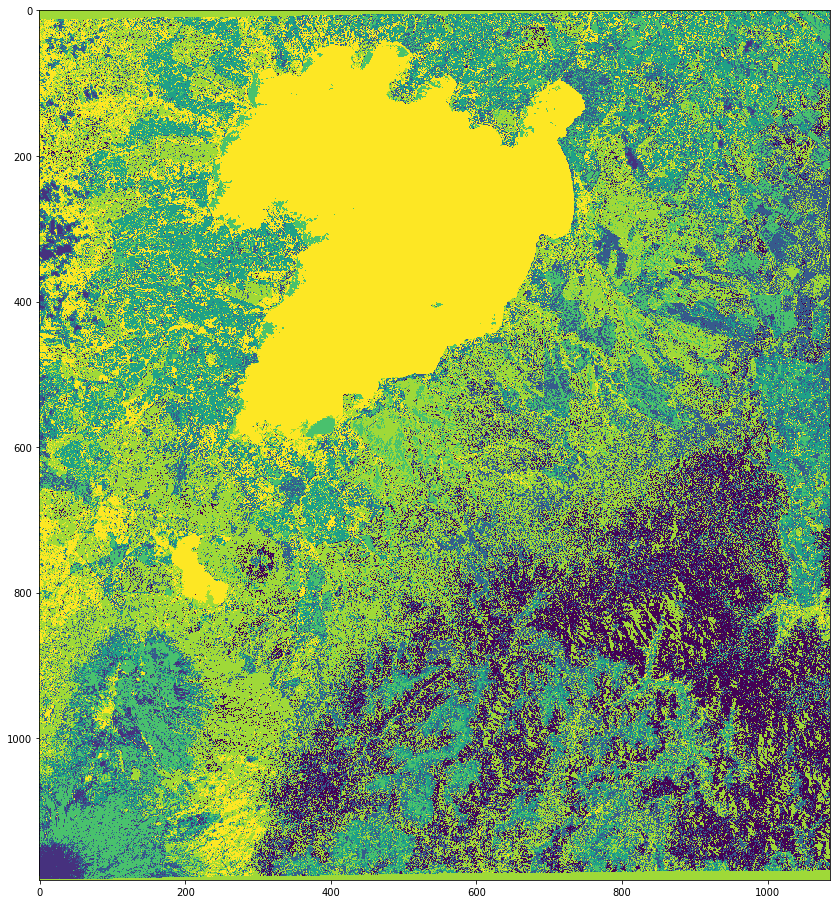

In [36]:
plt.figure(figsize=[16,16])
plt.imshow(classification)